In [1]:
from UTILITY_quickstart import *

In [2]:
#importedDefaultSettings = loadConfig("setLattice_configs/2024-10-14_twoBunch.yml")
#importedDefaultSettings = loadConfig("setLattice_configs/2024-10-22_oneBunch.yml")
#importedDefaultSettings = loadConfig("setLattice_configs/2024-10-22_oneBunch_twoIslandStudy.yml")
importedDefaultSettings = loadConfig("setLattice_configs/2025-06-17_twoBunch_forMuons_6GeV.yml")

In [3]:
csrTF = False
evalElement = "PENT"



inputBeamFilePathSuffix = importedDefaultSettings["inputBeamFilePathSuffix"]
bunchCount = importedDefaultSettings["bunchCount"]
tao = initializeTao(
    #inputBeamFilePathSuffix = '/beams/nmmToL0AFEND_2bunch_2024-02-16Clean/2024-02-16_2bunch_1e5Downsample_nudgeWeights.h5',
    inputBeamFilePathSuffix = inputBeamFilePathSuffix,
    
    csrTF = csrTF,
    numMacroParticles=1e4,
    scratchPath = "/tmp",
    randomizeFileNames = True
)

Environment set to:  /Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao
Tracking to end
CSR off
Overwriting lattice with setLattice() defaults
No defaults file provided to setLattice(). Using setLattice_configs/defaults.yml
Number of macro particles = 10000.0
Beam created, written to /tmp/beams/activeBeamFile_8828351036384551767.h5, and reinit to tao


In [4]:
baselineMatrix = getMatrix(tao, "BEGBC20", "MFFF", print = True);

-1.207484,-4.962570,-0.000000,-0.000000,0.000000,0.000012
-0.084683,-1.176201,0.000000,0.000000,0.000000,-0.000001
-0.000000,-0.000000,-0.636143,6.526881,0.000000,-0.000000
-0.000000,-0.000000,-0.094573,-0.601645,0.000000,-0.000000
-0.000003,-0.000021,0.000000,0.000000,1.000000,-0.007001
0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


In [5]:
setLattice(tao, **importedDefaultSettings)

In [6]:
launchTwissCorrection(tao)

No evalElement provided. Assuming golden lattice PR10571
Optimization Results:
Optimal Parameters: [4.19319006 1.98771984 2.95172175 1.40376845]
Objective Function Value at Optimal Parameters: 8.773895145881801e-10
Number of Iterations: 211
Converged: True


In [7]:
#tao.cmd("show ele PENT -all")
getMatrix(tao, "BEGBC20", "MFFF", print = True);

-1.153986,-4.900069,-0.000000,-0.000000,0.000000,-0.003165
-0.062343,-1.131285,0.000000,0.000000,0.000000,-0.000094
-0.000000,-0.000000,-0.732191,4.990598,0.000000,-0.000000
0.000000,-0.000000,-0.098276,-0.695916,0.000000,-0.000000
0.000089,0.003120,0.000000,0.000000,1.000000,-0.006796
0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


In [8]:
getMatrix(tao, "BEGBC20", "MFFF")[4][5]

-0.00679643

In [9]:
originalSettings = [ importedDefaultSettings[ele] for ele in ["Q1EkG", "Q2EkG", "Q3EkG", "Q4EkG", "Q5EkG", "Q6EkG"] ]
originalSettings

[96.7866, -92.5374, 66.1302, 79.3608, -14.0238, -85.3626]

In [10]:
# OPTIONAL: disable all apertures. Very nonphysical, but I want to see if this solves some headaches
# totalNumElements = len(tao.lat_list("*", "ele.name"))
# for eleII in range(totalNumElements):
#     try:
#         tao.cmd(f"set ele {eleII} APERTURE_AT = NO_APERTURE")
#     except:
#         pass

In [11]:
# activeSettings = importedDefaultSettings | { "L1PhaseSet" : -20, "L2PhaseSet" : -45 }

# setLattice(tao, **activeSettings)
# trackBeam(tao, **activeSettings)
# P = getBeamAtElement(tao, "BEGBC20")
# display(plotMod(P, 'z', 'pz', bins=300))
# plt.clf()

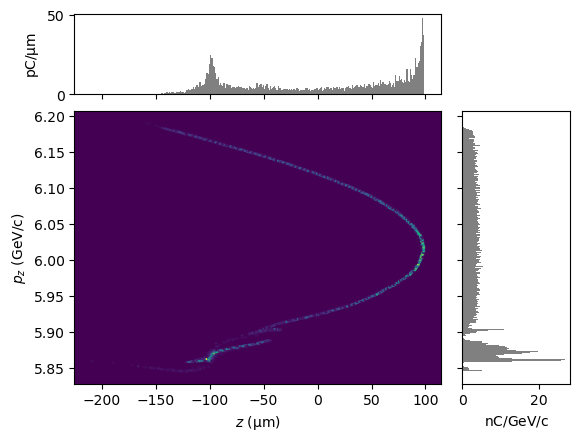

<Figure size 640x480 with 0 Axes>

In [12]:
trackBeam( tao, **importedDefaultSettings )
P = getBeamAtElement(tao, "PENT") 
display(plotMod(P, 'z', 'pz', bins=300))
plt.clf()

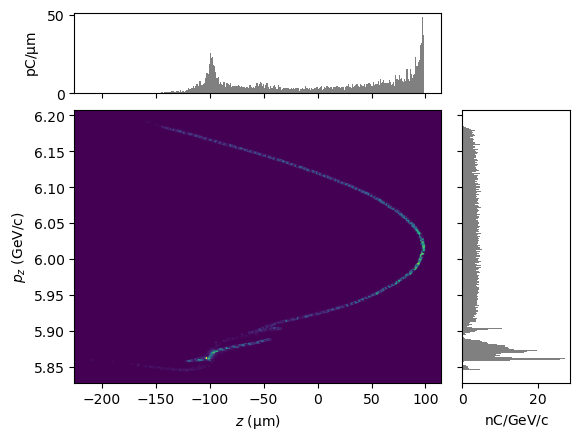

In [13]:
#Set up for partial tracking
P = getBeamAtElement(tao, "BEGBC20")
makeBeamActiveBeamFile(P, tao = tao)
trackBeam( tao, trackStart = "BEGBC20", trackEnd = "PENT", **importedDefaultSettings )

P = getBeamAtElement(tao, "PENT") 
display(plotMod(P, 'z', 'pz', bins=300))
plt.clf()

## Optimizer

In [14]:
from scipy.optimize import minimize

def objective(params, tao, targetR56):

    overrides = {
            "Q1EkG" : params[0],
            "Q2EkG" : params[1],
            "Q3EkG" : params[2],
            "Q4EkG" : params[3],
            "Q5EkG" : params[4],
            "Q6EkG" : params[5],
            }

    #print(overrides)
    
    setLattice(
        tao,
        **(importedDefaultSettings | overrides)

    )

    #targetR56 = -9.8e-3

    # newR56 = getMatrix(tao, "BEGBC20", "MFFF")[4][5]

    # error = (targetR56 - newR56) ** 2


    targetMatrix = baselineMatrix.copy()
    targetMatrix[4][5] = targetR56

    deltaMatrix = targetMatrix - getMatrix(tao, "BEGBC20", "MFFF")
    #Optional: Increase weight on R56 convergence
    deltaMatrix[4][5] = 1e3 * deltaMatrix[4][5]

    # print("Target matrix:")
    # displayMatrix(targetMatrix)
    # print("Delta matrix:")
    # displayMatrix(deltaMatrix)
    
    error = np.linalg.norm( deltaMatrix )
    
    #Optional: Prefer small changes to the quads
    changeCost = 1e-9 * np.linalg.norm( np.array( params ) - np.array( originalSettings ) ) ** 2
    error += changeCost

    return error

In [15]:
setLattice(tao, **importedDefaultSettings)

In [16]:
initialGuess = originalSettings

#For now, just hardcoding bounds... could generalize if required
#From "bounds.yml" as of 2025-06-18
# Q1EkGBounds :  (0, 388)  #BCON = 133
# Q2EkGBounds :  (-364, 0) #BCON = -136
# Q3EkGBounds :  (0, 299)  #BCON = 94
# Q4EkGBounds :  (0, 304)  #BCON = 118
# Q5EkGBounds :  (-117, 0) #BCON = -17
# Q6EkGBounds :  (-301, 0) #BCON = -142

bounds = [(0,388), (-364,0), (0, 299), (0, 304), (-117, 0), (-301, 0)]


# Perform optimization using Nelder-Mead
result = minimize(
    objective, 
    initialGuess, 
    method='Nelder-Mead',
    bounds = bounds,
    args = (tao, -9.8e-3)
)



print("Optimization Results:")
print(f"Optimal Parameters: {result.x}")
print(f"Objective Function Value at Optimal Parameters: {result.fun}")
print(f"Number of Iterations: {result.nit}")
print(f"Converged: {result.success}")

Optimization Results:
Optimal Parameters: [100.47172237 -92.07406992  64.03431022  87.10220343 -15.01553421
 -86.78780036]
Objective Function Value at Optimal Parameters: 0.04071863588840672
Number of Iterations: 427
Converged: True


In [17]:
objective( result.x, tao, -9.8e-3 ) 

0.04071863588840672

In [18]:
getMatrix(tao, "BEGBC20", "MFFF", print = True);

-1.205694,-4.963938,-0.000000,-0.000000,0.000000,0.028922
-0.083873,-1.174710,0.000000,0.000000,0.000000,0.001101
-0.000000,-0.000000,-0.636149,6.526896,0.000000,-0.000000
-0.000000,-0.000000,-0.094570,-0.601666,0.000000,-0.000000
-0.001098,-0.028508,0.000000,0.000000,1.000000,-0.009799
0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


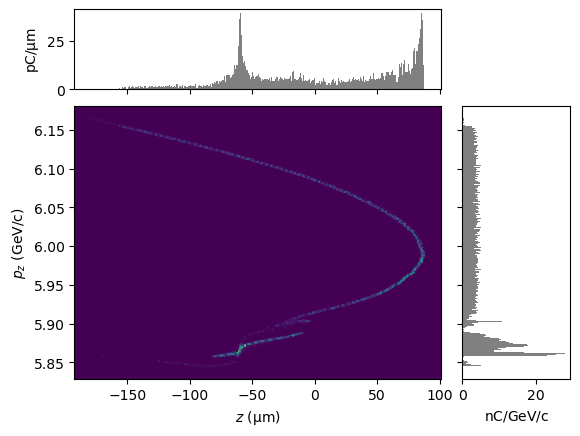

In [19]:
trackBeam( tao, trackStart = "BEGBC20", trackEnd = "PENT", **importedDefaultSettings )

P = getBeamAtElement(tao, "PENT") 
display(plotMod(P, 'z', 'pz', bins=300))
plt.clf()

## Loop



targetR56: -0.02
Optimization Results:
Optimal Parameters: [ 1.06553096e+02 -1.04552981e+02  6.14528015e+01  1.04530251e+02
 -6.81104367e-05 -1.07535945e+02]
Objective Function Value at Optimal Parameters: 1.120980251385719
Number of Iterations: 752
Converged: False


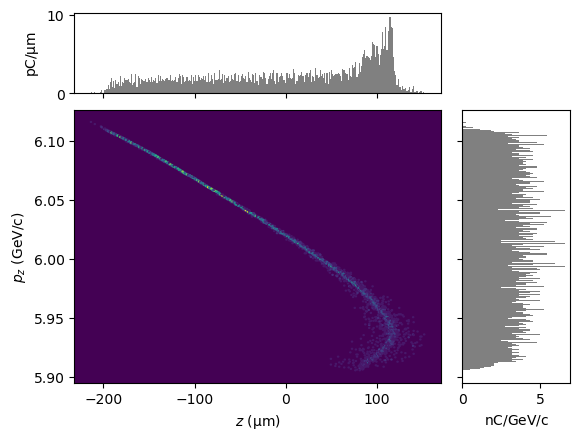

-1.752005,-4.816216,-0.000000,-0.000000,0.000000,0.209499
-0.377338,-1.608066,-0.000000,-0.000000,0.000000,0.028744
-0.000000,-0.000000,-0.121457,6.377501,0.000000,-0.000000
-0.000000,-0.000000,-0.155598,-0.063200,0.000000,-0.000000
-0.028693,-0.198452,0.000000,0.000000,1.000000,-0.019973
0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


WARNING! Expected drive/witness structure not found
FAILED


targetR56: -0.018000000000000002
Optimization Results:
Optimal Parameters: [103.95192934 -88.19327717  62.18849312  87.55270529 -12.05045033
 -91.21460815]
Objective Function Value at Optimal Parameters: 0.885651460500429
Number of Iterations: 763
Converged: False


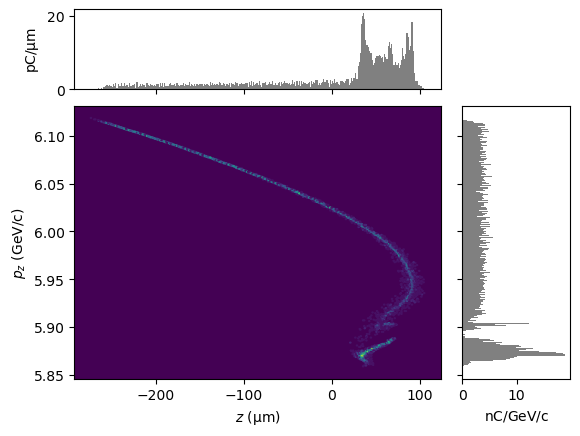

-1.746822,-4.788303,-0.000000,-0.000000,0.000000,0.181199
-0.376079,-1.603358,-0.000000,-0.000000,0.000000,0.024825
-0.000000,-0.000000,-0.398563,6.463683,0.000000,-0.000000
-0.000000,-0.000000,-0.133185,-0.349090,0.000000,-0.000000
-0.024780,-0.171657,0.000000,0.000000,1.000000,-0.017919
0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


Spacing: -8.208540815964819 um
Charge: 1.1295753600000002e-09


targetR56: -0.016000000000000004
Optimization Results:
Optimal Parameters: [  98.20712992 -102.13912291   67.88530087   69.71509707  -27.42973175
  -70.66248862]
Objective Function Value at Optimal Parameters: 1.584613579147921
Number of Iterations: 785
Converged: False


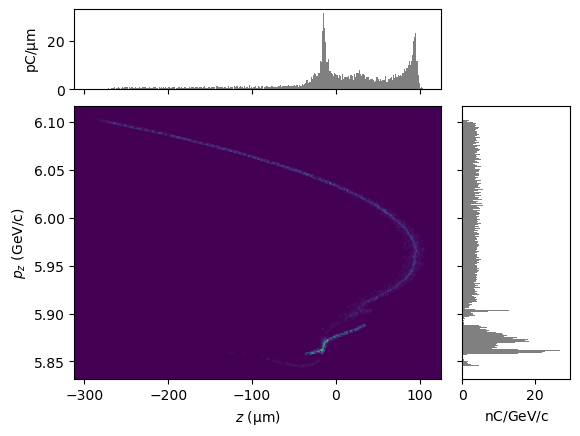

-2.097708,-4.646490,-0.000000,-0.000000,0.000000,0.206302
-0.623956,-1.858793,-0.000000,-0.000000,0.000000,0.041573
-0.000000,-0.000000,-0.047580,6.317082,0.000000,-0.000000
-0.000000,-0.000000,-0.158390,0.011799,0.000000,-0.000000
-0.041515,-0.190304,0.000000,0.000000,1.000000,-0.016094
0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


Spacing: 55.53878689620632 um
Charge: 1.2125772800000003e-09


targetR56: -0.014000000000000005
Optimization Results:
Optimal Parameters: [  97.1596722  -105.37180621   65.50817387   80.11655116   -5.68225198
  -96.78779666]
Objective Function Value at Optimal Parameters: 1.2705925686247315
Number of Iterations: 766
Converged: False


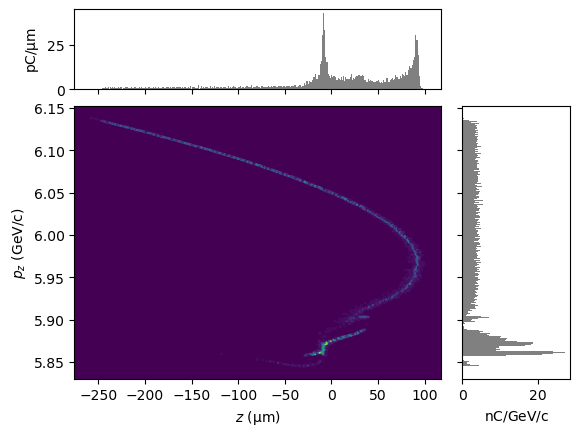

-1.897500,-4.743521,-0.000000,-0.000000,0.000000,0.139688
-0.475517,-1.715743,-0.000000,-0.000000,0.000000,0.022938
-0.000000,-0.000000,-0.118156,6.365508,0.000000,-0.000000
-0.000000,-0.000000,-0.155988,-0.059745,0.000000,-0.000000
-0.022900,-0.130863,0.000000,0.000000,1.000000,-0.013870
0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


Spacing: 44.88635786904906 um
Charge: 1.3376654400000002e-09


targetR56: -0.012000000000000007
Optimization Results:
Optimal Parameters: [101.91622988 -87.99110455  62.98340898  89.18706748 -17.44240846
 -86.2528357 ]
Objective Function Value at Optimal Parameters: 0.3907323491781745
Number of Iterations: 769
Converged: False


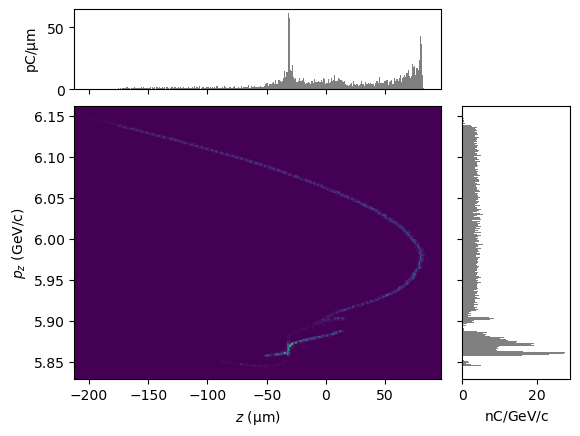

-1.294017,-4.936572,-0.000000,-0.000000,0.000000,0.058326
-0.124416,-1.247423,0.000000,0.000000,0.000000,0.003168
-0.000000,-0.000000,-0.391209,6.482105,0.000000,-0.000000
-0.000000,-0.000000,-0.133657,-0.341552,0.000000,-0.000000
-0.003157,-0.057118,0.000000,0.000000,1.000000,-0.011998
0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


Spacing: 65.49919334666288 um
Charge: 1.3581627200000001e-09


targetR56: -0.010000000000000009
Optimization Results:
Optimal Parameters: [100.74462518 -92.09290527  64.01760469  87.41182249 -17.38134769
 -84.39427019]
Objective Function Value at Optimal Parameters: 0.04359068295998259
Number of Iterations: 569
Converged: True


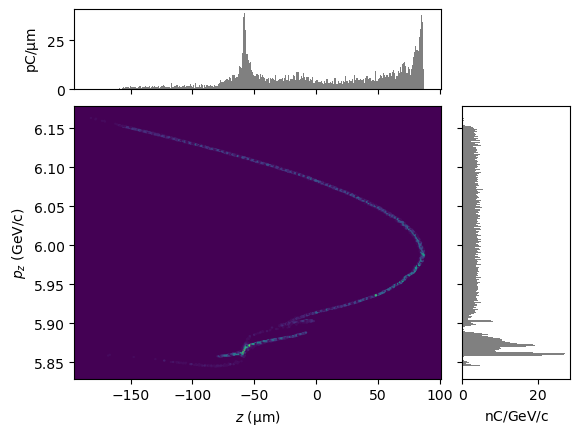

-1.205551,-4.964011,-0.000000,-0.000000,0.000000,0.030960
-0.083809,-1.174591,0.000000,0.000000,0.000000,0.001178
-0.000000,-0.000000,-0.636126,6.526900,0.000000,-0.000000
-0.000000,-0.000000,-0.094575,-0.601643,0.000000,0.000000
-0.001174,-0.030517,0.000000,0.000000,1.000000,-0.009999
0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


Spacing: 98.20547464136634 um
Charge: 1.4081326400000002e-09


In [20]:
for targetR56 in np.arange( -20e-3, -8e-3, 2e-3 ):
    
    print(f"\n\ntargetR56: {targetR56}") 

    try:
        result = minimize(
            objective, 
            initialGuess, 
            method='Nelder-Mead',
            bounds = bounds,
            args = (tao, targetR56)
        )
    
    
        print("Optimization Results:")
        print(f"Optimal Parameters: {result.x}")
        print(f"Objective Function Value at Optimal Parameters: {result.fun}")
        print(f"Number of Iterations: {result.nit}")
        print(f"Converged: {result.success}")
    
    
        objective( result.x, tao, targetR56 ) 
    
        trackBeam( tao, trackStart = "BEGBC20", trackEnd = "PENT", **importedDefaultSettings )
        P = getBeamAtElement(tao, "PENT") 
        display(plotMod(P, 'z', 'pz', bins=300))
        plt.clf()
    
        getMatrix(tao, "BEGBC20", "MFFF", print = True);
        
        PDrive, PWitness = getDriverAndWitness(P)
        print(f"Spacing: {1e6 * (np.median(PDrive.z) - np.median(PWitness.z))} um") 
        print(f"Charge: {P.charge}") 

    except:
        print("FAILED")